In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt

font = {'family' : 'DejaVu Sans',
        'size'   : 22}

plt.rc('font', **font)

In [3]:
import numpy as np
import matplotlib.patches as mpatches
import pickle
import os
import re
import random
import json
from pprint import pprint
import gzip
from joblib import Parallel, delayed


In [4]:
from util import read_models, action_set
import pickle

In [5]:
viridis = plt.get_cmap('viridis')

In [6]:
colors = np.array(viridis.colors)[np.linspace(0,len(viridis.colors)-1,5,dtype=int)]

# Overall rule set similarity

## Sample a single process, progress

In [7]:
num_nodes = 8

In [8]:
tmstp = '20210427-1407'
data_timestamp = '20210427_133329'

In [9]:
data_dir = '/home/bglaze/deepgraph/data'
stat_dir = f'{data_dir}/stats/'
param_dir = f'{data_dir}/parameters/'

In [10]:
# process = random.randint(0,4)
# repeat = random.randint(0,9)
process = 3
repeat = 8

file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'

params = json.load(open(f'{data_dir}/parameters/parameters-{file_string}.json'))

model_idx = params['model_idx']

true_actions = pickle.load(open(f'{data_dir}/inputs/actions_sync_{data_timestamp}.pickle','rb'))

edge_similarities = []
# sample_idxs = np.linspace(0, num_lines-1, num=nsample, endpoint=True, dtype=int)
# sampled_models = []

model_file = f'{data_dir}/models/models-{file_string}.txt.gz'

rewards = []
for reward, model in read_models(model_file, rewards=True, gzipped=True):
    a = set(true_actions[num_nodes][model_idx])
    b = action_set(model)
    inter = len(a & b)
    union = len(a | b)
#     jaccard = inter/(len(a) + len(b) - inter)
    jaccard = inter
    edge_similarities.append(jaccard)
    rewards.append(reward)

In [11]:
print(process, repeat)

3 8


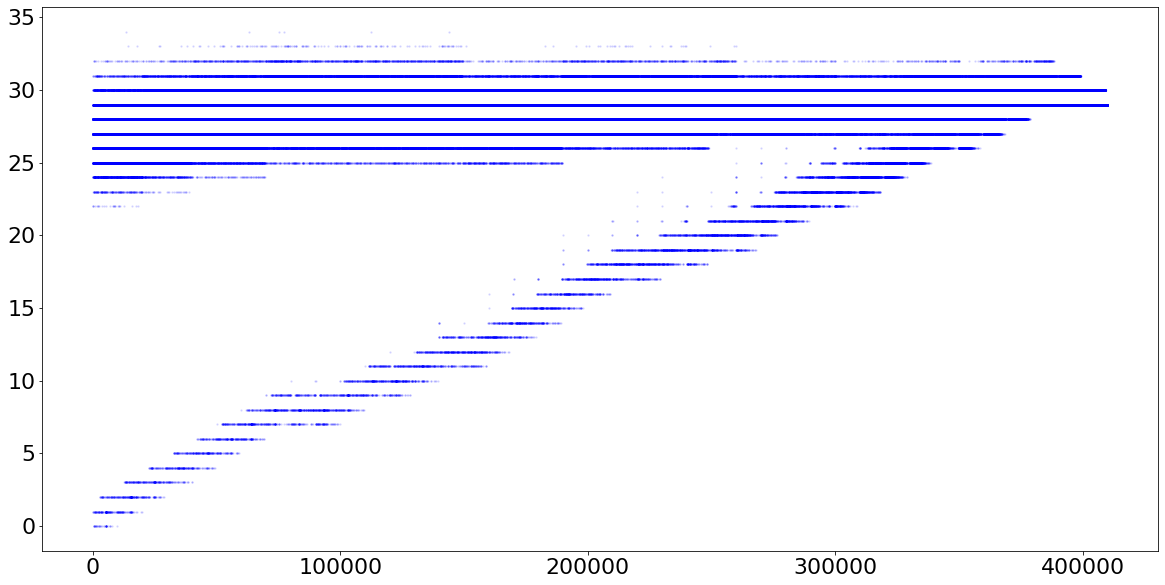

In [12]:
plt.figure(figsize=(20,10))
_=plt.scatter(range(len(edge_similarities)),edge_similarities,
              marker='.',
              s=8,
              color='blue',
              alpha=.1
             )

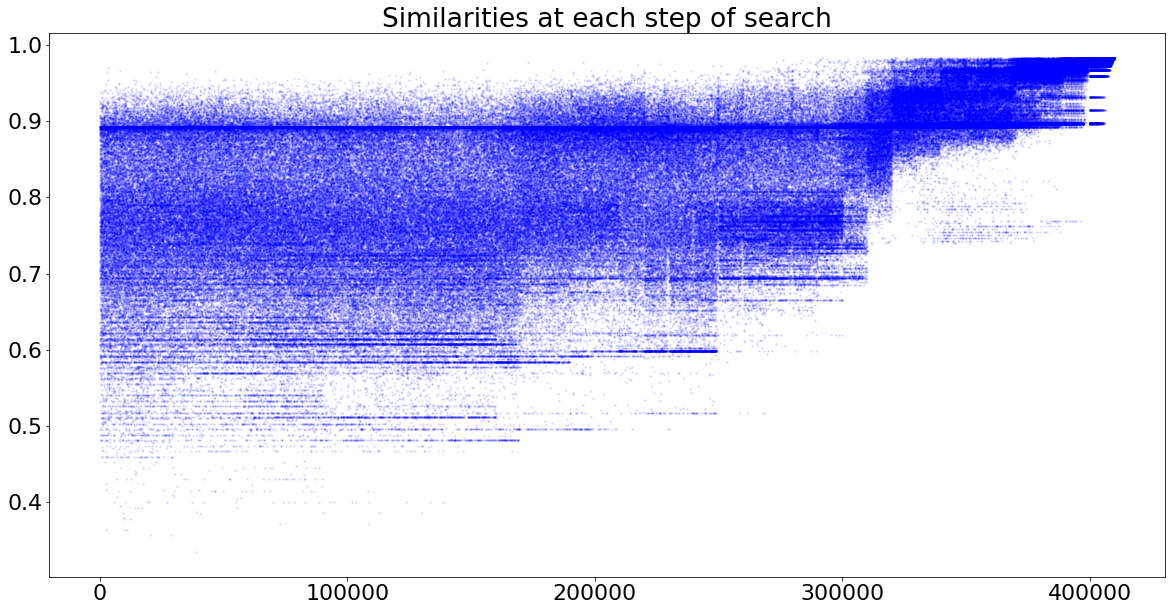

In [13]:
# process = random.randint(0,4)
# repeat = random.randint(0,9)
process = 0
repeat = 5

file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'

stats_file = open(f'{data_dir}/stats/search_stats-{file_string}.csv')
next(stats_file)
rewards = []
for line in stats_file:
    step,depth,reward = line.strip().split(',')
    rewards.append(float(reward))

plt.figure(figsize=(20,10))
_=plt.scatter(range(len(rewards)),rewards,
              marker='.',
              s=8,
              color='blue',
              alpha=.1
             )
_=plt.title('Similarities at each step of search')

In [14]:
print(process, repeat)

0 5


## Overall distribution of best results

In [15]:
# flat = (np.argwhere(np.array(edge_similarities[:100])==.3).flatten())

In [16]:
# for i,(reward, model) in enumerate(read_models(model_file, rewards=True, gzipped=True)):
#     if i in flat:
#         print(model)
#     if i > max(flat):
#         break

In [17]:
from util import gteq

In [18]:
def jaccard_dist(a,b):
    if len(a) == len(b) == 0:
        return 0.0
    inter = len(a & b)
    return inter/(len(a) + len(b) - inter) #, inter, len(a), len(b)

In [19]:
def freeze_edge_set(edge_set):
    return hash(tuple(sorted(list(edge_set))))

In [20]:
def test_uniqueness(file):
    unique_models = set()
    
    model_file = f'models-num_nodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}.txt.gz'
    
    misses = 0
    hits = 0
    with gzip.open(data_dir+'/models/'+model_file, 'rt') as f:
        for line in f:
            reward, model = line.split(',',1)
            m = json.loads(model)
            b = edge_set(m)
            frozen = freeze_edge_set(b)
            if frozen not in unique_models:
                unique_models.add(frozen)
                misses += 1
            else:
                hits +=1
                
    return hits, misses
    
# test_uniqueness(file)

In [21]:
def rule_set_intersection(num_nodes, process, repeat, tmstp):
    file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'
    
    params = json.load(open(param_dir + f'parameters-{file_string}.json'))
    model_idx = params['model_idx']
   
    true_actions = pickle.load(open(f'{data_dir}/inputs/actions_sync_{data_timestamp}.pickle','rb'))    

    model_file = f'{data_dir}/models/models-{file_string}.txt.gz'

    best_reward = 0.0
    best_jaccard = 0.0

    for reward, model in read_models(model_file, rewards=True, gzipped=True):
        a = set(true_actions[num_nodes][model_idx])
        b = action_set(model)
        inter = len(a & b)
        jaccard = inter/(len(a) + len(b) - inter)
        edge_similarities.append(jaccard)
        if gteq(reward, best_reward):
            b = action_set(model)
            inter = len(a & b)
            jaccard = inter/(len(a)+len(b)-inter)
            if jaccard > best_jaccard:
                best_jaccard = jaccard
                best_inter = (inter, len(a), len(b))

            best_reward = reward
                
    return best_reward, best_jaccard, best_inter

In [22]:
best_rule_set_jaccard_scores = {}

In [23]:
from itertools import product

In [157]:
num_nodes = [8, 16]

In [158]:
file_idxs = list(product(num_nodes, range(5), range(10), [tmstp]))

## Exact Matches

In [25]:
best_rewards = []
# num_nodes = 8
for _, process, repeat, tmstp in file_idxs:
    file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'
    stats_file = open(f'{data_dir}/stats/search_stats-{file_string}.csv')
    next(stats_file)
    best_reward = 0.0
    for line in stats_file:
        step,depth,reward = line.strip().split(',')
        reward = float(reward)
        if reward > best_reward:
            best_reward = reward
    best_rewards.append(best_reward)

In [26]:
best_rewards = np.array(best_rewards)

In [27]:
np.sum(best_rewards == 1.0)

38

In [28]:
len(best_rewards)

100

In [29]:
import math

In [30]:
np.sum(best_rewards > .99)

54

Text(0.5, 0, 'similarity')

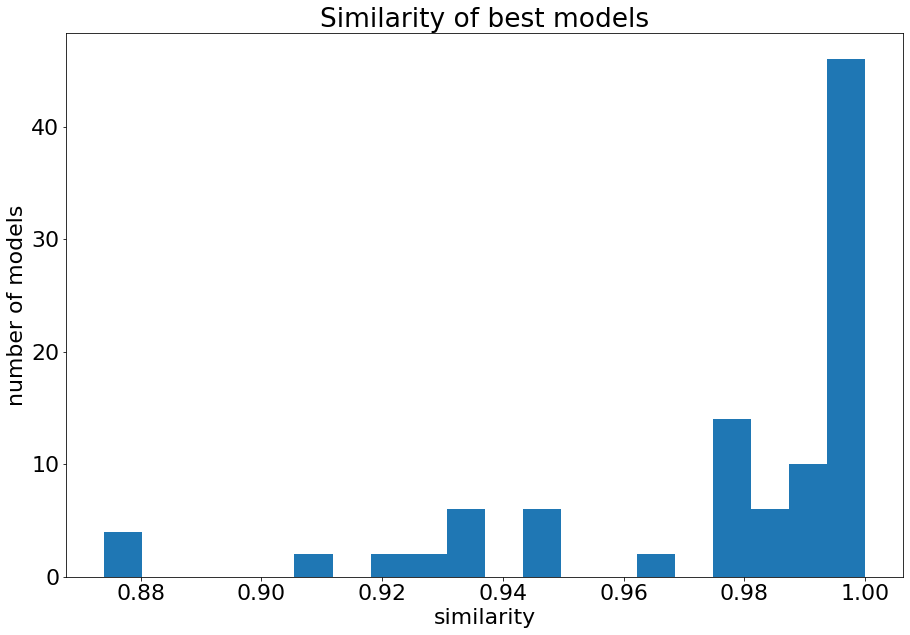

In [31]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes()
plt.title('Similarity of best models')
_=plt.hist(best_rewards, bins=20)
ax.set_ylabel('number of models')
ax.set_xlabel('similarity')

## Reward Progress

In [32]:
first_1000 = []
last_1000 = []

for num_nodes, process, repeat, tmstp in file_idxs:
    file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'
    stats_file = f'{data_dir}/stats/search_stats-{file_string}.csv'
    n=0
    for _ in open(stats_file):
        n+=1
        
    for i,line in enumerate(open(stats_file)):
        # skip header
        if i > 0 and i < 1000:
            step,depth,reward = line.strip().split(',')
            first_1000.append(float(reward))
        if i > n-1000:
            step,depth,reward = line.strip().split(',')
            last_1000.append(float(reward))


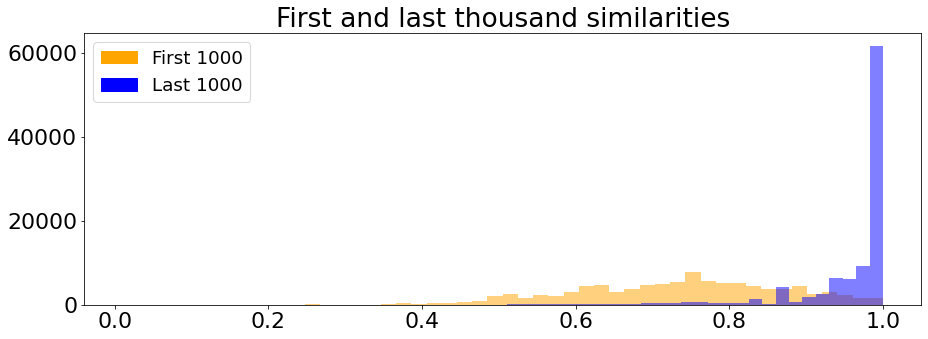

In [33]:
plt.figure(figsize=(15,5))
nbins=50
_ = plt.hist(first_1000, bins=nbins, alpha=.5, color='orange')
_ = plt.hist(last_1000, bins=nbins, alpha=.5, color='blue')

patches = [mpatches.Patch(color='orange', label='First 1000'),
           mpatches.Patch(color='blue', label='Last 1000')]
_=plt.legend(handles=patches, fontsize='small')

_=plt.title('First and last thousand similarities')

## Rule Set intersection

In [34]:
parallel = Parallel(n_jobs=10, verbose=8)
file_idxs = list(product([8], range(5), range(10), [tmstp]))
best_rule_set_jaccard_scores[8] = parallel(delayed(rule_set_intersection)(num_nodes, process, repeat, tmstp) 
                                            for num_nodes, process, repeat, tmstp in file_idxs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   27.0s
[Parallel(n_jobs=10)]: Done  38 out of  50 | elapsed:   43.2s remaining:   13.6s
[Parallel(n_jobs=10)]: Done  45 out of  50 | elapsed:   47.5s remaining:    5.3s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   56.1s finished


In [36]:
file_idxs = list(product([16], range(5), range(10), [tmstp]))
best_rule_set_jaccard_scores[16] = parallel(delayed(rule_set_intersection)(num_nodes, process, repeat, tmstp) 
                                            for num_nodes, process, repeat, tmstp in file_idxs)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done  38 out of  50 | elapsed:  5.9min remaining:  1.9min
[Parallel(n_jobs=10)]: Done  45 out of  50 | elapsed:  6.3min remaining:   42.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  7.5min finished


In [94]:
from matplotlib.lines import Line2D

<function matplotlib.pyplot.legend(*args, **kwargs)>

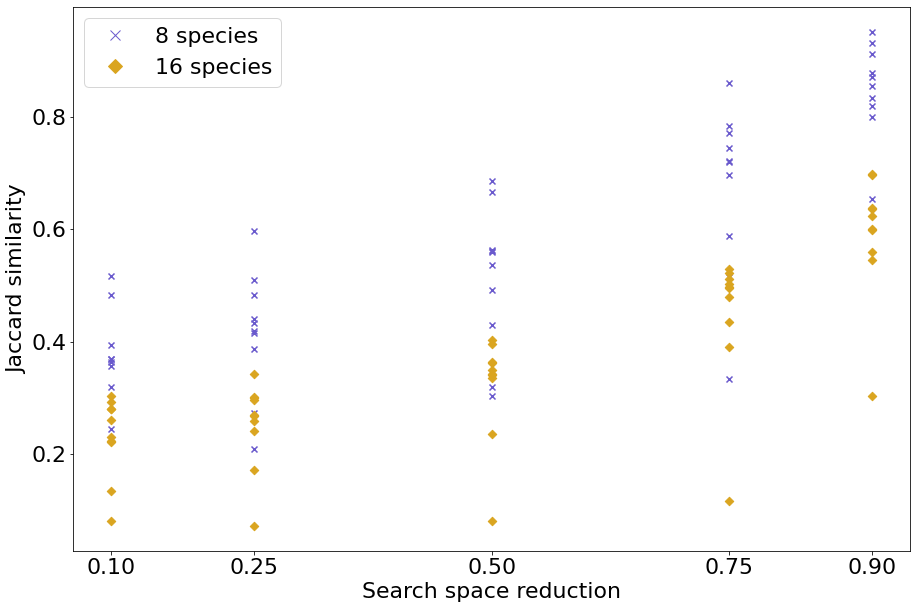

In [164]:
fig, ax = plt.subplots(figsize=(15,10))
process_jaccards = {}

markers = {8: ('slateblue', 'x'),
           16:('goldenrod', 'D')}

percentages = {}

for num_nodes, process, repeat, tmstp in file_idxs:
    file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'

    params = json.load(open(param_dir + f'parameters-{file_string}.json'))
    percentages[process] = params['percent_actions']

for n in [8, 16]:
    rewards, jaccards, intersection_stats = zip(*best_rule_set_jaccard_scores[n])

    process_jaccards[n] = {process:[] for process in percentages}

    for i in range(len(jaccards)):
        jaccard = jaccards[i]
        num_nodes, process, repeat, tmstp = file_idxs[i]
        process_jaccards[n][process].append(jaccard)

    color, marker = markers[n]
    for process, pjaccards in process_jaccards[n].items():
        ax.scatter([1-percentages[process]]*len(pjaccards), pjaccards, color=color, marker=marker)

legend = [Line2D([0], [0], color=color, marker=marker, markersize=10, label=n, linestyle='None')
                   for n,(color, marker) in markers.items()]
        
_=plt.legend(handles = legend, labels = ['8 species', '16 species'])
        
_=plt.xticks([1-v for v in percentages.values()])

ax.set_xlabel('Search space reduction')
ax.set_ylabel('Jaccard similarity')
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

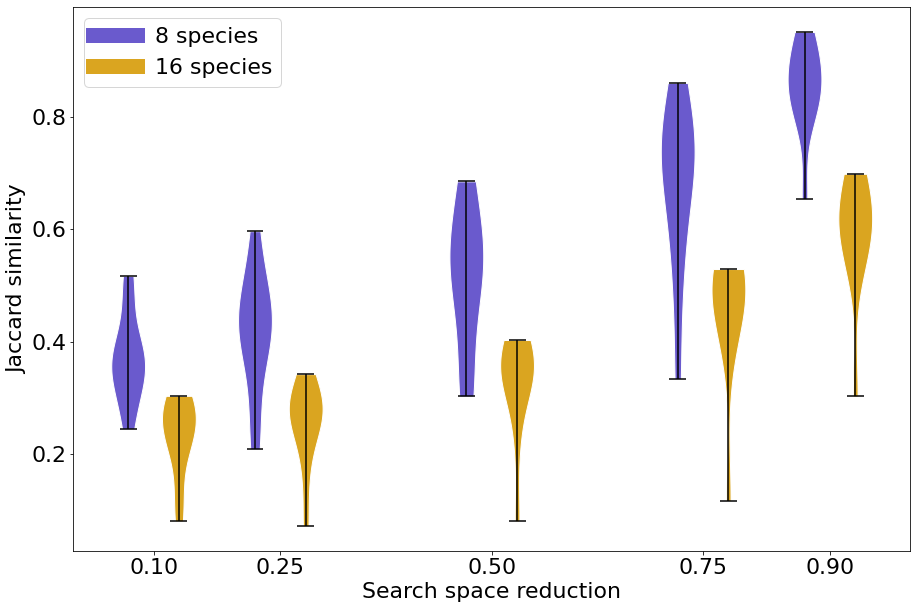

In [184]:
fig, ax = plt.subplots(figsize=(15,10))
process_jaccards = {}

markers = {8: ('slateblue', 'x'),
           16:('goldenrod', 'D')}

percentages = {}

for num_nodes, process, repeat, tmstp in file_idxs:
    file_string = f'bias_experiment_numnodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}'

    params = json.load(open(param_dir + f'parameters-{file_string}.json'))
    percentages[process] = params['percent_actions']

num_nodes = [8, 16]
shift = np.linspace(start=-.015*len(num_nodes), stop=.015*len(num_nodes), num=len(num_nodes))

i=0
for n in num_nodes:
    rewards, jaccards, intersection_stats = zip(*best_rule_set_jaccard_scores[n])

    process_jaccards[n] = {process:[] for process in percentages}

    for j in range(len(jaccards)):
        jaccard = jaccards[j]
        num_nodes, process, repeat, tmstp = file_idxs[j]
        process_jaccards[n][process].append(jaccard)

    color, marker = markers[n]
    for process, pjaccards in process_jaccards[n].items():
        parts = ax.violinplot(positions=[1-percentages[process]+shift[i]], dataset=pjaccards, widths=.04)
    
        for pc in parts['bodies']:
            pc.set_facecolor(color)
            pc.set_edgecolor('white')
            pc.set_alpha(1)
        parts['cbars'].set_color('black')
        parts['cmins'].set_color('black')
        parts['cmaxes'].set_color('black')
    i+=1

legend = [Line2D([0], [0], color=color, lw=15, label=n)
                   for n,(color, marker) in markers.items()]
        
_=plt.legend(handles = legend, labels = ['8 species', '16 species'], loc=2)
        
_=plt.xticks([1-v for v in percentages.values()])

ax.set_xlabel('Search space reduction')
ax.set_ylabel('Jaccard similarity')
plt.legend

## Per node rule set similarity

In [39]:
def freeze_model(model):
    return freeze_edge_set(edge_set(model))

In [40]:
def node_rule_set(model):
    rules = {}
    for dst,(act,inh) in model.items():
        dst = int(dst)
        rules[dst] = set()
        for src in act:
            rules[dst].add((int(src),0))
        for src in inh:
            rules[dst].add((int(src),1))
    return rules

In [41]:
nsample = 10000

In [42]:
from math import isclose

In [43]:
def pernode_rule_intersections(file, check_unique=False):
    file_params = re.split('[-_.]', file)
    process = file_params[5]
    repeat = file_params[7]
    params = json.load(open(param_dir + f'parameters-num_nodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}.json'))
    
    true_model = models[num_nodes][params['model_idx']]
    true_model_rule_set = node_rule_set(true_model.edges)
    
    model_file = f'models-num_nodes-{num_nodes}_process-{process}_repeat-{repeat}_tmstp-{tmstp}.txt.gz'

    unique_models = set()
    
    best_rule_jaccards = []
    best_rule_lens = []
    best_rule_inters = []
    
    with gzip.open(data_dir+'/models/'+model_file, 'rt') as f:
        sample_idxs = np.linspace(0, num_lines-1, num=nsample, endpoint=True, dtype=int)

        best_reward = 0.0
        for line in f:
            reward, model = line.split(',',1)
            reward= float(reward)
            # find the models with the best rewards
            if reward > best_reward:
                best_reward = reward
                best_rule_jaccards = []
                best_rule_lens = []
                best_rule_inters = []
                
            if isclose(reward, best_reward):
                m = json.loads(model)
                if check_unique:
                    frozen = freeze_model(m)
                    unique = frozen not in unique_models
                else:
                    unique = True
            
                if unique:
                    true = true_model_rule_set
                    model = node_rule_set(m)
                    for dst in true:
                        inter = len(true[dst] & model[dst])
                        if len(true[dst]) == len(model[dst]) == 0:
                            jaccard = 0.0
                        else:
                            jaccard = inter/(len(true[dst]) + len(model[dst]) - inter)
                        best_rule_inters.append(inter)
                        best_rule_jaccards.append(jaccard)
                        best_rule_lens.append( (len(true[dst]), len(model[dst])) )
        return np.array(best_rule_jaccards), np.array(best_rule_lens), np.array(best_rule_inters)

In [44]:
parallel = Parallel(n_jobs=20)
best_rule_intersection_scores = parallel(
    delayed(pernode_rule_intersections)(file) for i,file in enumerate(files))   

NameError: name 'files' is not defined

In [ ]:
best_rule_jaccards, best_rule_lens, best_rule_inters = zip(*best_rule_intersection_scores)

In [ ]:
all_best_rule_jaccards = np.concatenate(best_rule_jaccards)

In [ ]:
all_best_rule_inters = np.concatenate(best_rule_inters)

In [ ]:
all_best_rule_lens = np.concatenate(best_rule_lens)

In [ ]:
print(len(all_best_rule_jaccards))

In [ ]:
_=plt.hist(all_best_rule_jaccards, bins=100)

In [ ]:
_=plt.hist(all_best_rule_inters)

In [ ]:
_=plt.hist(all_best_rule_inters/all_best_rule_lens[:,1])